<a href="https://colab.research.google.com/github/Itziar23/prueba/blob/master/ACNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import os
from google.colab import drive
drive.mount('/content/gdrive')
ruta='gdrive/My Drive/dataset/CAMUS/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Standard
import os
import sys
import datetime
import numpy as np
import matplotlib.pyplot as plt
# Utils
import h5py
# Deep Learning
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [ ]:
PROJECT_ROOT_DIR = "/content/gdrive/MyDrive/Colab Notebooks/"
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

In [ ]:
pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import os

%matplotlib inline

In [ ]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
print(os.getcwd())

/content


In [ ]:
import sys  
sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks/architectures')
from laddernet import LadderNet
from unet import UNet
from resunet import ResUNet

In [ ]:
import sys  
sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks/metrics')
from multiclass_dice import multiclass_dice

In [ ]:
import sys  
sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks/metrics')
from iou import iou

In [ ]:
train_path = ruta + "training/patient0001/"

In [ ]:
def mhd_to_array(path):
    """
    Read an *.mhd file stored in path and return it as a numpy array.
    """
    return sitk.GetArrayFromImage(sitk.ReadImage(path, sitk.sitkFloat32))

In [ ]:
image = sitk.GetArrayFromImage(sitk.ReadImage(train_path + "patient0001_4CH_ED.mhd", sitk.sitkFloat32))
mask = sitk.GetArrayFromImage(sitk.ReadImage(train_path + "patient0001_4CH_ED_gt.mhd", sitk.sitkFloat32))

In [ ]:
train_path = ruta + "training/patient1001/"

In [ ]:
image = sitk.GetArrayFromImage(sitk.ReadImage(train_path + "patient1001_4CH_ES.mhd", sitk.sitkFloat32))
mask = sitk.GetArrayFromImage(sitk.ReadImage(train_path + "patient1001_4CH_ES_gt.mhd", sitk.sitkFloat32))

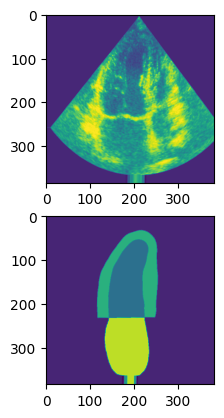

In [ ]:
fig, ax = plt.subplots(2)
ax[0].imshow(image) # End Diastolic frame
ax[1].imshow(mask) # End Diastolic mask
plt.show()

In [ ]:
earlystop = EarlyStopping(monitor='val_multiclass_dice', min_delta=0, patience=5,
                          verbose=1, mode="max", restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_multiclass_dice', factor=0.2, patience=2,
                              verbose=1, mode="max", min_lr=1e-5)

In [ ]:
f = h5py.File("gdrive/My Drive/dataset/image_dataset.hdf5", "r")

In [ ]:
train_frames = f["train_4ch_ed_frames"][:,:,:,:]
train_masks = f["train_4ch_ed_masks"][:,:,:,:]
test_frames = f["test_4ch_ed_frames"][:,:,:,:]
test_masks = f["test_4ch_ed_masks"][:,:,:,:]

In [ ]:
image_tr=train_frames[0]
np.shape(image)
mask_tr=train_masks[0]

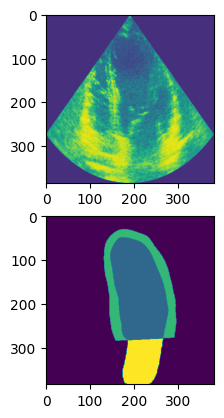

In [ ]:
fig, ax = plt.subplots(2)
ax[0].imshow(image_tr) # End Diastolic frame
ax[1].imshow(mask_tr) # End Diastolic mask
plt.show()

In [ ]:
train_frames, valid_frames, train_masks, valid_masks = train_test_split(train_frames, train_masks)

In [ ]:
import sys  
sys.path.insert(0, '/content/gdrive/MyDrive/Colab Notebooks/architectures')

from acnn import ACNN

In [ ]:
model_acnn= ACNN(input_size=(384, 384, 1),num_classes=4)

In [ ]:
model_acnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 384, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 384, 384, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 192, 192, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 96, 96, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 128)       73856 

In [ ]:
model_acnn.compile(optimizer=Adam(learning_rate=1e-3), loss="sparse_categorical_crossentropy", metrics=[multiclass_dice, iou,"accuracy"])

In [ ]:
history_acnn=model_acnn.fit(x=train_frames,
                    y=train_masks,
                    validation_data=(valid_frames, valid_masks),
                    batch_size=5,
                    epochs=3,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/3
135/135 [==============================] - 29s 86ms/step - loss: 0.3807 - multiclass_dice: 0.0014 - iou: 7.8368e-04 - accuracy: 0.8731 - val_loss: 0.2835 - val_multiclass_dice: 0.0000e+00 - val_iou: 0.0000e+00 - val_accuracy: 0.8860 - lr: 0.0010
Epoch 2/3
135/135 [==============================] - 11s 82ms/step - loss: 0.2858 - multiclass_dice: 0.2059 - iou: 0.1232 - accuracy: 0.8769 - val_loss: 0.2625 - val_multiclass_dice: 0.3157 - val_iou: 0.1923 - val_accuracy: 0.8899 - lr: 0.0010
Epoch 3/3
135/135 [==============================] - 11s 84ms/step - loss: 0.2752 - multiclass_dice: 0.2855 - iou: 0.1749 - accuracy: 0.8803 - val_loss: 0.2544 - val_multiclass_dice: 0.3733 - val_iou: 0.2345 - val_accuracy: 0.8920 - lr: 0.0010


In [ ]:
loss_acnn_4 = model_acnn.evaluate(x=test_frames,y=test_masks)

29/29 [==============================] - 9s 185ms/step - loss: 0.0303 - multiclass_dice: 0.0285 - iou: 0.0180 - accuracy: 0.9878


In [ ]:
print(history_acnn.history.keys())

dict_keys(['loss', 'multiclass_dice', 'iou', 'accuracy', 'val_loss', 'val_multiclass_dice', 'val_iou', 'val_accuracy', 'lr'])


Saving figure keras_learning_curves_plot_1


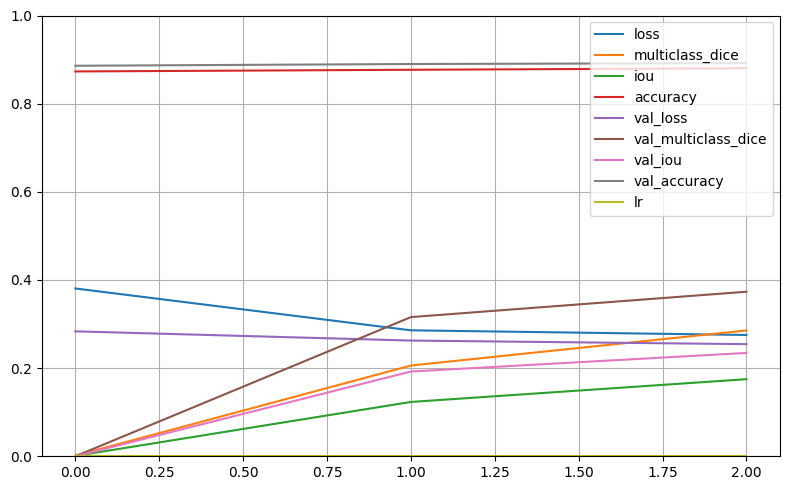

In [ ]:
df=pd.DataFrame(history_acnn.history)
df.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot_1")
plt.show()

In [ ]:
df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/acnn_name.csv')

In [ ]:
model_acnn.save_weights("/content/gdrive/MyDrive/Colab Notebooks/models/acnn_4ch_ed.h5")

In [ ]:
print(type(model_acnn.history))

<class 'keras.callbacks.History'>


AUMENTO DE DATOS

In [ ]:
f = h5py.File("gdrive/My Drive/dataset/image_dataset_augmented.hdf5", "r")

In [ ]:
train_frames = f["train_4ch_ed_frames"][:,:,:,:]
train_masks = f["train_4ch_ed_masks"][:,:,:,:]
test_frames = f["test_4ch_ed_frames"][:,:,:,:]
test_masks = f["test_4ch_ed_masks"][:,:,:,:]

In [ ]:
train_frames, valid_frames, train_masks, valid_masks = train_test_split(train_frames, train_masks)

In [ ]:
model_acnn= ACNN(input_size=(384, 384, 1),num_classes=4)

In [ ]:
model_acnn.compile(optimizer=Adam(learning_rate=1e-3), loss="sparse_categorical_crossentropy", metrics=[multiclass_dice, iou,"accuracy"])

In [ ]:
history_acnn=model_acnn.fit(x=train_frames,
                    y=train_masks,
                    validation_data=(valid_frames, valid_masks),
                    batch_size=5,
                    epochs=3,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/3
270/270 [==============================] - 44s 85ms/step - loss: 0.2847 - multiclass_dice: 6.4792e-04 - iou: 3.5501e-04 - accuracy: 0.9242 - val_loss: 0.2314 - val_multiclass_dice: 0.0000e+00 - val_iou: 0.0000e+00 - val_accuracy: 0.9258 - lr: 0.0010
Epoch 2/3
270/270 [==============================] - 22s 81ms/step - loss: 0.2390 - multiclass_dice: 0.0506 - iou: 0.0302 - accuracy: 0.9249 - val_loss: 0.2168 - val_multiclass_dice: 0.0016 - val_iou: 8.0838e-04 - val_accuracy: 0.9258 - lr: 0.0010
Epoch 3/3
270/270 [==============================] - 22s 83ms/step - loss: 0.2235 - multiclass_dice: 0.1770 - iou: 0.1078 - accuracy: 0.9267 - val_loss: 0.2019 - val_multiclass_dice: 0.1319 - val_iou: 0.0732 - val_accuracy: 0.9269 - lr: 0.0010


In [ ]:
loss_acnn_4 = model_acnn.evaluate(x=test_frames,y=test_masks)

29/29 [==============================] - 10s 184ms/step - loss: 0.0319 - multiclass_dice: 0.0148 - iou: 0.0083 - accuracy: 0.9870


In [ ]:
print(history_acnn.history.keys())

dict_keys(['loss', 'multiclass_dice', 'iou', 'accuracy', 'val_loss', 'val_multiclass_dice', 'val_iou', 'val_accuracy', 'lr'])


Saving figure keras_learning_curves_plot_1


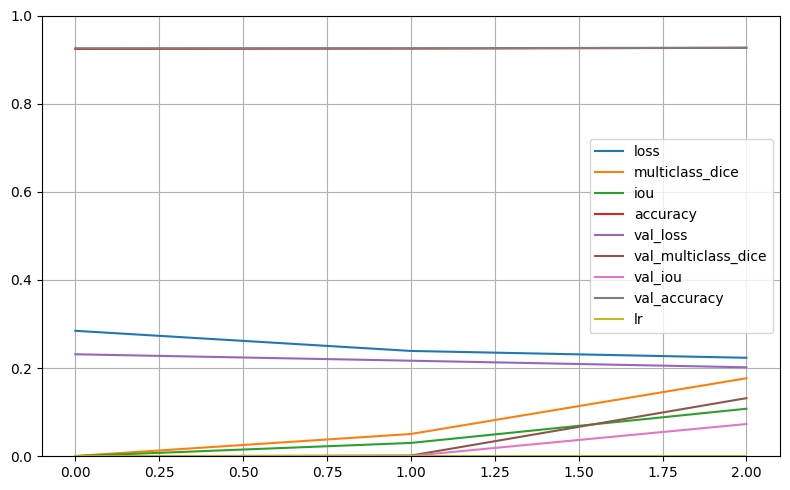

In [ ]:
df=pd.DataFrame(history_acnn.history)
df.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
save_fig("keras_learning_curves_plot_1")
plt.show()

In [ ]:
df.to_csv('/content/gdrive/MyDrive/Colab Notebooks/acnn_augmented.csv')

In [ ]:
model_acnn.save_weights("/content/gdrive/MyDrive/Colab Notebooks/models/acnn_augmented_4ch_ed.h5")

PREPROCESADO

In [ ]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

NameError: ignored